In [1]:
# ==========================================
# RAF-DB EMOTION RECOGNITION - MULTI-ATTRIBUTE TRAINING
# Handles confusion between ALL emotions using multi-head classification
# ==========================================

# Cell 2: Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
import torchvision.transforms.functional as TF

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import os
from pathlib import Path
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: Tesla T4


In [2]:
# Cell 3: Configuration
class Config:
    # Paths (UPDATE THESE to your Kaggle dataset paths)
    TRAIN_DIR = '/kaggle/input/rafdataset/train'  # UPDATE THIS
    TEST_DIR = '/kaggle/input/rafdataset/test'    # UPDATE THIS
    
    # Model
    MODEL_NAME = 'resnet18'  # or 'resnet34', 'resnet50', 'efficientnet_b0'
    NUM_CLASSES = 7
    PRETRAINED = True
    
    # Training
    BATCH_SIZE = 64  # Increase for GPU
    NUM_EPOCHS = 50
    LEARNING_RATE = 0.0001
    WEIGHT_DECAY = 0.0001
    EARLY_STOPPING_PATIENCE = 10
    
    # Image
    IMAGE_SIZE = (224, 224)
    
    # Data split
    VAL_SPLIT = 0.1  # 10% for validation
    
    # Loss weights
    EMOTION_WEIGHT = 1.0
    VALENCE_WEIGHT = 0.3
    AROUSAL_WEIGHT = 0.2
    DOMINANCE_WEIGHT = 0.2
    
    # Focal Loss
    FOCAL_ALPHA = None  # Will be calculated
    FOCAL_GAMMA = 2.0
    
    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    NUM_WORKERS = 2
    
    # Correct RAF-DB emotion mapping
    EMOTIONS = {
        '1': 'surprise',
        '2': 'fear',
        '3': 'disgust',
        '4': 'happy',
        '5': 'sad',
        '6': 'angry',
        '7': 'neutral'
    }
    
    EMOTION_TO_IDX = {
        'surprise': 0,
        'fear': 1,
        'disgust': 2,
        'happy': 3,
        'sad': 4,
        'angry': 5,
        'neutral': 6
    }
    
    IDX_TO_EMOTION = {v: k for k, v in EMOTION_TO_IDX.items()}

config = Config()
print(f"Training on: {config.DEVICE}")

Training on: cuda


In [3]:
# Cell 4: Emotion Attributes Mapping
def get_emotion_attributes(emotion_idx):
    """
    Get psychological attributes for each emotion
    Based on Russell's Circumplex Model
    
    Returns: (valence, arousal, dominance)
        - Valence: 0=positive, 1=negative
        - Arousal: 0=low, 1=high  
        - Dominance: 0=weak, 1=strong
    """
    attributes = {
        0: (0, 1, 1),  # Happy: positive, high arousal, strong
        1: (1, 1, 1),  # Angry: negative, high arousal, strong
        2: (1, 0, 0),  # Sad: negative, low arousal, weak
        3: (1, 1, 0),  # Fear: negative, high arousal, weak
        4: (1, 0, 0),  # Disgust: negative, low arousal, weak
        5: (0, 1, 0),  # Surprise: positive, high arousal, weak
        6: (0, 0, 0),  # Neutral: neutral, low arousal, weak
    }
    return attributes[emotion_idx]

def get_attribute_labels_batch(emotion_labels):
    """Convert batch of emotion labels to attribute labels"""
    batch_size = len(emotion_labels)
    valence_labels = torch.zeros(batch_size, dtype=torch.long)
    arousal_labels = torch.zeros(batch_size, dtype=torch.long)
    dominance_labels = torch.zeros(batch_size, dtype=torch.long)
    
    for i, emotion in enumerate(emotion_labels):
        val, ar, dom = get_emotion_attributes(emotion.item())
        valence_labels[i] = val
        arousal_labels[i] = ar
        dominance_labels[i] = dom
    
    return valence_labels, arousal_labels, dominance_labels


In [4]:
# Cell 5: Dataset Class (FIXED for torchvision)
class RAF_DB_Dataset(Dataset):
    """RAF-DB Dataset with torchvision transforms"""
    
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load image with OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("✅ Dataset class ready")

✅ Dataset class ready


In [5]:
# Cell 6: Data Augmentation (Using torchvision - NO CONFLICTS)
from torchvision import transforms
import torch.nn.functional as F

def get_train_transforms(image_size):
    """Training transforms using torchvision (built-in)"""
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(image_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_val_transforms(image_size):
    """Validation transforms"""
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

print("✅ Transforms ready (using torchvision)")

✅ Transforms ready (using torchvision)


In [6]:
# Cell 7: Load and Organize Data
def load_data_from_numbered_folders(data_dir, emotion_map):
    """
    Load images from numbered folders (1/, 2/, 3/, etc.)
    
    Returns:
        image_paths: List of image file paths
        labels: List of emotion indices (0-6)
    """
    image_paths = []
    labels = []
    
    print(f"\nScanning: {data_dir}")
    
    for emotion_num, emotion_name in emotion_map.items():
        emotion_folder = os.path.join(data_dir, emotion_num)
        
        if not os.path.exists(emotion_folder):
            print(f"⚠️  Folder not found: {emotion_folder}")
            continue
        
        # Get all images in this emotion folder
        images = [f for f in os.listdir(emotion_folder) 
                 if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        
        emotion_idx = config.EMOTION_TO_IDX[emotion_name]
        
        for img_file in images:
            img_path = os.path.join(emotion_folder, img_file)
            image_paths.append(img_path)
            labels.append(emotion_idx)
        
        print(f"  {emotion_name:10s} ({emotion_num}): {len(images)} images")
    
    return image_paths, labels

# Load training data
print("="*70)
print("LOADING DATA")
print("="*70)

train_paths, train_labels = load_data_from_numbered_folders(config.TRAIN_DIR, config.EMOTIONS)
test_paths, test_labels = load_data_from_numbered_folders(config.TEST_DIR, config.EMOTIONS)

print(f"\nTotal training images: {len(train_paths)}")
print(f"Total test images: {len(test_paths)}")

# Split training into train + val
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels,
    test_size=config.VAL_SPLIT,
    random_state=42,
    stratify=train_labels
)

print(f"\nAfter split:")
print(f"  Train: {len(train_paths)} images")
print(f"  Val:   {len(val_paths)} images")
print(f"  Test:  {len(test_paths)} images")

# Analyze class distribution
print(f"\n{'='*70}")
print("CLASS DISTRIBUTION")
print(f"{'='*70}")

train_counter = Counter(train_labels)
for emotion_idx in sorted(train_counter.keys()):
    emotion_name = config.IDX_TO_EMOTION[emotion_idx]
    count = train_counter[emotion_idx]
    percentage = (count / len(train_labels)) * 100
    print(f"{emotion_name:10s}: {count:5d} ({percentage:5.2f}%)")

# Calculate class weights for loss
max_count = max(train_counter.values())
class_weights = []
for i in range(config.NUM_CLASSES):
    if i in train_counter:
        weight = max_count / train_counter[i]
    else:
        weight = 1.0
    class_weights.append(weight)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(config.DEVICE)
print(f"\nClass weights: {class_weights.cpu().numpy()}")


LOADING DATA

Scanning: /kaggle/input/rafdataset/train
  surprise   (1): 1290 images
  fear       (2): 281 images
  disgust    (3): 717 images
  happy      (4): 4772 images
  sad        (5): 1982 images
  angry      (6): 705 images
  neutral    (7): 2524 images

Scanning: /kaggle/input/rafdataset/test
  surprise   (1): 329 images
  fear       (2): 74 images
  disgust    (3): 160 images
  happy      (4): 1185 images
  sad        (5): 478 images
  angry      (6): 162 images
  neutral    (7): 680 images

Total training images: 12271
Total test images: 3068

After split:
  Train: 11043 images
  Val:   1228 images
  Test:  3068 images

CLASS DISTRIBUTION
surprise  :  1161 (10.51%)
fear      :   253 ( 2.29%)
disgust   :   645 ( 5.84%)
happy     :  4295 (38.89%)
sad       :  1784 (16.16%)
angry     :   634 ( 5.74%)
neutral   :  2271 (20.57%)

Class weights: [ 3.699397  16.976284   6.6589146  1.         2.4075112  6.774448
  1.8912374]


In [7]:
# Cell 8: Create DataLoaders
print("\nCreating datasets and dataloaders...")

# Create datasets
train_dataset = RAF_DB_Dataset(
    train_paths, train_labels,
    transform=get_train_transforms(config.IMAGE_SIZE)
)

val_dataset = RAF_DB_Dataset(
    val_paths, val_labels,
    transform=get_val_transforms(config.IMAGE_SIZE)
)

test_dataset = RAF_DB_Dataset(
    test_paths, test_labels,
    transform=get_val_transforms(config.IMAGE_SIZE)
)

# Weighted sampling for training (handle class imbalance)
sample_weights = [class_weights[label].item() for label in train_labels]
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    sampler=sampler,
    num_workers=config.NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS,
    pin_memory=True
)

print(f"✅ DataLoaders created:")
print(f"   Train: {len(train_loader)} batches")
print(f"   Val:   {len(val_loader)} batches")
print(f"   Test:  {len(test_loader)} batches")


Creating datasets and dataloaders...
✅ DataLoaders created:
   Train: 173 batches
   Val:   20 batches
   Test:  48 batches


In [8]:
# Cell 9: Multi-Attribute Model
class RAF_DB_MultiAttribute_Net(nn.Module):
    """
    Multi-attribute emotion recognition model
    
    Predicts:
    1. Emotion (7 classes)
    2. Valence (positive/negative)
    3. Arousal (high/low)
    4. Dominance (strong/weak)
    """
    
    def __init__(self, num_classes=7, model_name='resnet18', pretrained=True, dropout=0.5):
        super(RAF_DB_MultiAttribute_Net, self).__init__()
        
        # Backbone
        if model_name == 'resnet18':
            self.backbone = models.resnet18(pretrained=pretrained)
            num_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        elif model_name == 'resnet34':
            self.backbone = models.resnet34(pretrained=pretrained)
            num_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        elif model_name == 'resnet50':
            self.backbone = models.resnet50(pretrained=pretrained)
            num_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        elif model_name == 'efficientnet_b0':
            self.backbone = models.efficientnet_b0(pretrained=pretrained)
            num_features = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()
        else:
            raise ValueError(f"Unknown model: {model_name}")
        
        # Shared features
        self.shared_features = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout)
        )
        
        # Emotion head (main task)
        self.emotion_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout / 2),
            nn.Linear(256, num_classes)
        )
        
        # Valence head
        self.valence_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )
        
        # Arousal head
        self.arousal_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )
        
        # Dominance head
        self.dominance_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        shared = self.shared_features(features)
        
        emotion_logits = self.emotion_head(shared)
        valence_logits = self.valence_head(shared)
        arousal_logits = self.arousal_head(shared)
        dominance_logits = self.dominance_head(shared)
        
        return emotion_logits, valence_logits, arousal_logits, dominance_logits

# Create model
print("\n" + "="*70)
print("CREATING MODEL")
print("="*70)

model = RAF_DB_MultiAttribute_Net(
    num_classes=config.NUM_CLASSES,
    model_name=config.MODEL_NAME,
    pretrained=config.PRETRAINED,
    dropout=0.5
).to(config.DEVICE)

print(f"✅ Model: {config.MODEL_NAME}")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Trainable: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")



CREATING MODEL


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


✅ Model: resnet18
   Parameters: 11,771,597
   Trainable: 11,771,597


In [9]:
# Cell 10: Loss Functions
class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class MultiAttributeLoss(nn.Module):
    """Combined multi-attribute loss"""
    
    def __init__(self, class_weights=None,
                 emotion_weight=1.0, valence_weight=0.3,
                 arousal_weight=0.2, dominance_weight=0.2):
        super(MultiAttributeLoss, self).__init__()
        
        self.emotion_criterion = FocalLoss(alpha=class_weights, gamma=2.0)
        self.valence_criterion = nn.CrossEntropyLoss()
        self.arousal_criterion = nn.CrossEntropyLoss()
        self.dominance_criterion = nn.CrossEntropyLoss()
        
        self.emotion_weight = emotion_weight
        self.valence_weight = valence_weight
        self.arousal_weight = arousal_weight
        self.dominance_weight = dominance_weight
    
    def forward(self, emotion_logits, valence_logits, arousal_logits, dominance_logits,
                emotion_targets, valence_targets, arousal_targets, dominance_targets):
        
        emotion_loss = self.emotion_criterion(emotion_logits, emotion_targets)
        valence_loss = self.valence_criterion(valence_logits, valence_targets)
        arousal_loss = self.arousal_criterion(arousal_logits, arousal_targets)
        dominance_loss = self.dominance_criterion(dominance_logits, dominance_targets)
        
        total_loss = (self.emotion_weight * emotion_loss +
                     self.valence_weight * valence_loss +
                     self.arousal_weight * arousal_loss +
                     self.dominance_weight * dominance_loss)
        
        return total_loss, emotion_loss, valence_loss, arousal_loss, dominance_loss

# Create loss function
criterion = MultiAttributeLoss(
    class_weights=class_weights,
    emotion_weight=config.EMOTION_WEIGHT,
    valence_weight=config.VALENCE_WEIGHT,
    arousal_weight=config.AROUSAL_WEIGHT,
    dominance_weight=config.DOMINANCE_WEIGHT
)

print("✅ Loss: Multi-Attribute Loss (Focal + 3 auxiliary tasks)")


✅ Loss: Multi-Attribute Loss (Focal + 3 auxiliary tasks)


In [10]:
# Cell 11: Optimizer and Scheduler
optimizer = optim.AdamW(
    model.parameters(),
    lr=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY
)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,
    T_mult=2
)

print("✅ Optimizer: AdamW")
print("✅ Scheduler: CosineAnnealingWarmRestarts")

✅ Optimizer: AdamW
✅ Scheduler: CosineAnnealingWarmRestarts


In [11]:
# Cell 12: Training Functions
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    
    running_loss = 0.0
    running_emotion_loss = 0.0
    running_valence_loss = 0.0
    running_arousal_loss = 0.0
    running_dominance_loss = 0.0
    
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training')
    
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Get attribute labels
        valence_labels, arousal_labels, dominance_labels = get_attribute_labels_batch(labels)
        valence_labels = valence_labels.to(device)
        arousal_labels = arousal_labels.to(device)
        dominance_labels = dominance_labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        emotion_logits, valence_logits, arousal_logits, dominance_logits = model(images)
        
        # Calculate loss
        total_loss, emotion_loss, valence_loss, arousal_loss, dominance_loss = criterion(
            emotion_logits, valence_logits, arousal_logits, dominance_logits,
            labels, valence_labels, arousal_labels, dominance_labels
        )
        
        # Backward pass
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Statistics
        running_loss += total_loss.item()
        running_emotion_loss += emotion_loss.item()
        running_valence_loss += valence_loss.item()
        running_arousal_loss += arousal_loss.item()
        running_dominance_loss += dominance_loss.item()
        
        _, predicted = torch.max(emotion_logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({
            'loss': f'{running_loss/len(pbar):.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    return {
        'loss': running_loss / len(dataloader),
        'emotion_loss': running_emotion_loss / len(dataloader),
        'valence_loss': running_valence_loss / len(dataloader),
        'arousal_loss': running_arousal_loss / len(dataloader),
        'dominance_loss': running_dominance_loss / len(dataloader),
        'accuracy': 100. * correct / total
    }

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validating'):
            images = images.to(device)
            labels = labels.to(device)
            
            # Get attribute labels
            valence_labels, arousal_labels, dominance_labels = get_attribute_labels_batch(labels)
            valence_labels = valence_labels.to(device)
            arousal_labels = arousal_labels.to(device)
            dominance_labels = dominance_labels.to(device)
            
            # Forward pass
            emotion_logits, valence_logits, arousal_logits, dominance_logits = model(images)
            
            # Calculate loss
            total_loss, _, _, _, _ = criterion(
                emotion_logits, valence_logits, arousal_logits, dominance_logits,
                labels, valence_labels, arousal_labels, dominance_labels
            )
            
            running_loss += total_loss.item()
            
            _, predicted = torch.max(emotion_logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return {
        'loss': running_loss / len(dataloader),
        'accuracy': 100. * correct / total,
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels)
    }

In [12]:

# Cell 13: Training Loop
print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)

best_val_acc = 0.0
patience_counter = 0
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(1, config.NUM_EPOCHS + 1):
    print(f"\n{'='*70}")
    print(f"Epoch {epoch}/{config.NUM_EPOCHS}")
    print(f"{'='*70}")
    
    # Train
    train_results = train_one_epoch(model, train_loader, criterion, optimizer, config.DEVICE)
    
    # Validate
    val_results = validate(model, val_loader, criterion, config.DEVICE)
    
    # Update scheduler
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_results['loss'])
    history['train_acc'].append(train_results['accuracy'])
    history['val_loss'].append(val_results['loss'])
    history['val_acc'].append(val_results['accuracy'])
    
    # Print results
    print(f"\nTrain - Loss: {train_results['loss']:.4f} | Acc: {train_results['accuracy']:.2f}%")
    print(f"  Components - Emotion: {train_results['emotion_loss']:.4f} | "
          f"Valence: {train_results['valence_loss']:.4f} | "
          f"Arousal: {train_results['arousal_loss']:.4f} | "
          f"Dominance: {train_results['dominance_loss']:.4f}")
    print(f"Val   - Loss: {val_results['loss']:.4f} | Acc: {val_results['accuracy']:.2f}%")
    
    # Save best model
    if val_results['accuracy'] > best_val_acc:
        best_val_acc = val_results['accuracy']
        patience_counter = 0
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'config': config.__dict__,
            'history': history
        }, 'best_model.pth')
        
        print(f"🎯 New best! Val Acc: {best_val_acc:.2f}%")
    else:
        patience_counter += 1
        print(f"⏳ Patience: {patience_counter}/{config.EARLY_STOPPING_PATIENCE}")
    
    # Early stopping
    if patience_counter >= config.EARLY_STOPPING_PATIENCE:
        print(f"\n⚠️  Early stopping triggered!")
        break

print(f"\n{'='*70}")
print("✅ TRAINING COMPLETE!")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"{'='*70}")


STARTING TRAINING

Epoch 1/50


Validating: 100%|██████████| 20/20 [00:04<00:00,  4.85it/s]



Train - Loss: 7.9194 | Acc: 34.76%
  Components - Emotion: 7.4934 | Valence: 0.6518 | Arousal: 0.6200 | Dominance: 0.5325
Val   - Loss: 4.2601 | Acc: 22.88%
🎯 New best! Val Acc: 22.88%

Epoch 2/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.08it/s]



Train - Loss: 4.3129 | Acc: 52.06%
  Components - Emotion: 4.0100 | Valence: 0.4934 | Arousal: 0.4711 | Dominance: 0.3036
Val   - Loss: 3.8487 | Acc: 36.56%
🎯 New best! Val Acc: 36.56%

Epoch 3/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  7.88it/s]



Train - Loss: 2.8638 | Acc: 64.13%
  Components - Emotion: 2.6308 | Valence: 0.3917 | Arousal: 0.3689 | Dominance: 0.2086
Val   - Loss: 3.5129 | Acc: 44.54%
🎯 New best! Val Acc: 44.54%

Epoch 4/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]



Train - Loss: 2.0500 | Acc: 72.34%
  Components - Emotion: 1.8607 | Valence: 0.3311 | Arousal: 0.2959 | Dominance: 0.1537
Val   - Loss: 3.3596 | Acc: 54.72%
🎯 New best! Val Acc: 54.72%

Epoch 5/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]



Train - Loss: 1.6346 | Acc: 77.07%
  Components - Emotion: 1.4719 | Valence: 0.2951 | Arousal: 0.2415 | Dominance: 0.1297
Val   - Loss: 2.9973 | Acc: 60.34%
🎯 New best! Val Acc: 60.34%

Epoch 6/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  7.89it/s]



Train - Loss: 1.2284 | Acc: 81.49%
  Components - Emotion: 1.0913 | Valence: 0.2460 | Arousal: 0.2115 | Dominance: 0.1048
Val   - Loss: 2.8372 | Acc: 63.11%
🎯 New best! Val Acc: 63.11%

Epoch 7/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.09it/s]



Train - Loss: 1.0070 | Acc: 84.12%
  Components - Emotion: 0.8829 | Valence: 0.2231 | Arousal: 0.1900 | Dominance: 0.0960
Val   - Loss: 2.8585 | Acc: 65.47%
🎯 New best! Val Acc: 65.47%

Epoch 8/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.23it/s]



Train - Loss: 0.8277 | Acc: 86.20%
  Components - Emotion: 0.7173 | Valence: 0.2052 | Arousal: 0.1682 | Dominance: 0.0764
Val   - Loss: 2.6197 | Acc: 68.00%
🎯 New best! Val Acc: 68.00%

Epoch 9/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]



Train - Loss: 0.7161 | Acc: 87.24%
  Components - Emotion: 0.6124 | Valence: 0.1979 | Arousal: 0.1530 | Dominance: 0.0688
Val   - Loss: 2.6980 | Acc: 69.06%
🎯 New best! Val Acc: 69.06%

Epoch 10/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.37it/s]



Train - Loss: 0.6781 | Acc: 88.04%
  Components - Emotion: 0.5796 | Valence: 0.1835 | Arousal: 0.1537 | Dominance: 0.0634
Val   - Loss: 2.7286 | Acc: 67.92%
⏳ Patience: 1/10

Epoch 11/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]



Train - Loss: 1.0155 | Acc: 84.56%
  Components - Emotion: 0.8945 | Valence: 0.2255 | Arousal: 0.1777 | Dominance: 0.0893
Val   - Loss: 3.1425 | Acc: 63.11%
⏳ Patience: 2/10

Epoch 12/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.05it/s]



Train - Loss: 0.9677 | Acc: 85.95%
  Components - Emotion: 0.8541 | Valence: 0.2091 | Arousal: 0.1709 | Dominance: 0.0833
Val   - Loss: 3.1391 | Acc: 65.23%
⏳ Patience: 3/10

Epoch 13/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.04it/s]



Train - Loss: 0.8771 | Acc: 86.24%
  Components - Emotion: 0.7739 | Valence: 0.1914 | Arousal: 0.1516 | Dominance: 0.0773
Val   - Loss: 3.0871 | Acc: 70.20%
🎯 New best! Val Acc: 70.20%

Epoch 14/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]



Train - Loss: 0.7992 | Acc: 87.58%
  Components - Emotion: 0.7002 | Valence: 0.1831 | Arousal: 0.1441 | Dominance: 0.0764
Val   - Loss: 2.8909 | Acc: 70.28%
🎯 New best! Val Acc: 70.28%

Epoch 15/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.07it/s]



Train - Loss: 0.6872 | Acc: 88.87%
  Components - Emotion: 0.6007 | Valence: 0.1628 | Arousal: 0.1273 | Dominance: 0.0606
Val   - Loss: 2.9180 | Acc: 71.09%
🎯 New best! Val Acc: 71.09%

Epoch 16/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.37it/s]



Train - Loss: 0.6083 | Acc: 90.16%
  Components - Emotion: 0.5276 | Valence: 0.1533 | Arousal: 0.1175 | Dominance: 0.0561
Val   - Loss: 2.9515 | Acc: 70.44%
⏳ Patience: 1/10

Epoch 17/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]



Train - Loss: 0.5551 | Acc: 90.33%
  Components - Emotion: 0.4795 | Valence: 0.1371 | Arousal: 0.1197 | Dominance: 0.0527
Val   - Loss: 2.9842 | Acc: 73.94%
🎯 New best! Val Acc: 73.94%

Epoch 18/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]



Train - Loss: 0.4336 | Acc: 92.14%
  Components - Emotion: 0.3686 | Valence: 0.1242 | Arousal: 0.0975 | Dominance: 0.0410
Val   - Loss: 3.1674 | Acc: 71.50%
⏳ Patience: 1/10

Epoch 19/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]



Train - Loss: 0.3770 | Acc: 93.24%
  Components - Emotion: 0.3173 | Valence: 0.1149 | Arousal: 0.0902 | Dominance: 0.0356
Val   - Loss: 3.0717 | Acc: 75.00%
🎯 New best! Val Acc: 75.00%

Epoch 20/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  7.23it/s]



Train - Loss: 0.3446 | Acc: 93.65%
  Components - Emotion: 0.2922 | Valence: 0.1023 | Arousal: 0.0809 | Dominance: 0.0276
Val   - Loss: 2.8851 | Acc: 75.41%
🎯 New best! Val Acc: 75.41%

Epoch 21/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.35it/s]



Train - Loss: 0.3066 | Acc: 94.23%
  Components - Emotion: 0.2586 | Valence: 0.0935 | Arousal: 0.0727 | Dominance: 0.0269
Val   - Loss: 3.0179 | Acc: 75.90%
🎯 New best! Val Acc: 75.90%

Epoch 22/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]



Train - Loss: 0.2422 | Acc: 95.08%
  Components - Emotion: 0.1969 | Valence: 0.0857 | Arousal: 0.0744 | Dominance: 0.0232
Val   - Loss: 3.1055 | Acc: 76.47%
🎯 New best! Val Acc: 76.47%

Epoch 23/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]



Train - Loss: 0.2080 | Acc: 95.50%
  Components - Emotion: 0.1681 | Valence: 0.0775 | Arousal: 0.0605 | Dominance: 0.0224
Val   - Loss: 2.9427 | Acc: 76.95%
🎯 New best! Val Acc: 76.95%

Epoch 24/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.23it/s]



Train - Loss: 0.1775 | Acc: 96.08%
  Components - Emotion: 0.1438 | Valence: 0.0647 | Arousal: 0.0572 | Dominance: 0.0143
Val   - Loss: 3.1623 | Acc: 77.93%
🎯 New best! Val Acc: 77.93%

Epoch 25/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]



Train - Loss: 0.1528 | Acc: 96.54%
  Components - Emotion: 0.1219 | Valence: 0.0567 | Arousal: 0.0531 | Dominance: 0.0166
Val   - Loss: 3.1762 | Acc: 78.66%
🎯 New best! Val Acc: 78.66%

Epoch 26/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.24it/s]



Train - Loss: 0.1329 | Acc: 97.02%
  Components - Emotion: 0.1049 | Valence: 0.0533 | Arousal: 0.0469 | Dominance: 0.0132
Val   - Loss: 3.0125 | Acc: 78.75%
🎯 New best! Val Acc: 78.75%

Epoch 27/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  7.57it/s]



Train - Loss: 0.1152 | Acc: 97.13%
  Components - Emotion: 0.0894 | Valence: 0.0507 | Arousal: 0.0431 | Dominance: 0.0100
Val   - Loss: 3.1068 | Acc: 78.66%
⏳ Patience: 1/10

Epoch 28/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.14it/s]



Train - Loss: 0.1193 | Acc: 97.27%
  Components - Emotion: 0.0943 | Valence: 0.0477 | Arousal: 0.0428 | Dominance: 0.0106
Val   - Loss: 3.0362 | Acc: 79.56%
🎯 New best! Val Acc: 79.56%

Epoch 29/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]



Train - Loss: 0.1190 | Acc: 97.35%
  Components - Emotion: 0.0929 | Valence: 0.0506 | Arousal: 0.0428 | Dominance: 0.0117
Val   - Loss: 3.1358 | Acc: 79.80%
🎯 New best! Val Acc: 79.80%

Epoch 30/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]



Train - Loss: 0.0997 | Acc: 97.46%
  Components - Emotion: 0.0765 | Valence: 0.0452 | Arousal: 0.0401 | Dominance: 0.0078
Val   - Loss: 3.0676 | Acc: 79.48%
⏳ Patience: 1/10

Epoch 31/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.24it/s]



Train - Loss: 0.3538 | Acc: 94.58%
  Components - Emotion: 0.3042 | Valence: 0.0901 | Arousal: 0.0787 | Dominance: 0.0344
Val   - Loss: 3.2322 | Acc: 74.35%
⏳ Patience: 2/10

Epoch 32/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]



Train - Loss: 0.3977 | Acc: 93.50%
  Components - Emotion: 0.3417 | Valence: 0.1044 | Arousal: 0.0883 | Dominance: 0.0352
Val   - Loss: 3.3659 | Acc: 74.76%
⏳ Patience: 3/10

Epoch 33/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.30it/s]



Train - Loss: 0.3711 | Acc: 94.27%
  Components - Emotion: 0.3228 | Valence: 0.0898 | Arousal: 0.0721 | Dominance: 0.0348
Val   - Loss: 3.4318 | Acc: 73.78%
⏳ Patience: 4/10

Epoch 34/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  7.97it/s]



Train - Loss: 0.3728 | Acc: 93.86%
  Components - Emotion: 0.3229 | Valence: 0.0886 | Arousal: 0.0775 | Dominance: 0.0395
Val   - Loss: 3.3390 | Acc: 75.98%
⏳ Patience: 5/10

Epoch 35/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.04it/s]



Train - Loss: 0.3345 | Acc: 94.25%
  Components - Emotion: 0.2877 | Valence: 0.0878 | Arousal: 0.0715 | Dominance: 0.0305
Val   - Loss: 3.5558 | Acc: 77.04%
⏳ Patience: 6/10

Epoch 36/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  7.73it/s]



Train - Loss: 0.3275 | Acc: 94.51%
  Components - Emotion: 0.2820 | Valence: 0.0857 | Arousal: 0.0672 | Dominance: 0.0315
Val   - Loss: 3.5218 | Acc: 75.00%
⏳ Patience: 7/10

Epoch 37/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]



Train - Loss: 0.3144 | Acc: 94.38%
  Components - Emotion: 0.2678 | Valence: 0.0856 | Arousal: 0.0737 | Dominance: 0.0306
Val   - Loss: 3.3305 | Acc: 74.10%
⏳ Patience: 8/10

Epoch 38/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.12it/s]



Train - Loss: 0.2666 | Acc: 95.13%
  Components - Emotion: 0.2271 | Valence: 0.0747 | Arousal: 0.0655 | Dominance: 0.0199
Val   - Loss: 3.2995 | Acc: 77.69%
⏳ Patience: 9/10

Epoch 39/50


Validating: 100%|██████████| 20/20 [00:02<00:00,  8.23it/s]


Train - Loss: 0.2527 | Acc: 95.63%
  Components - Emotion: 0.2146 | Valence: 0.0694 | Arousal: 0.0614 | Dominance: 0.0254
Val   - Loss: 3.5558 | Acc: 76.71%
⏳ Patience: 10/10

⚠️  Early stopping triggered!

✅ TRAINING COMPLETE!
Best Validation Accuracy: 79.80%


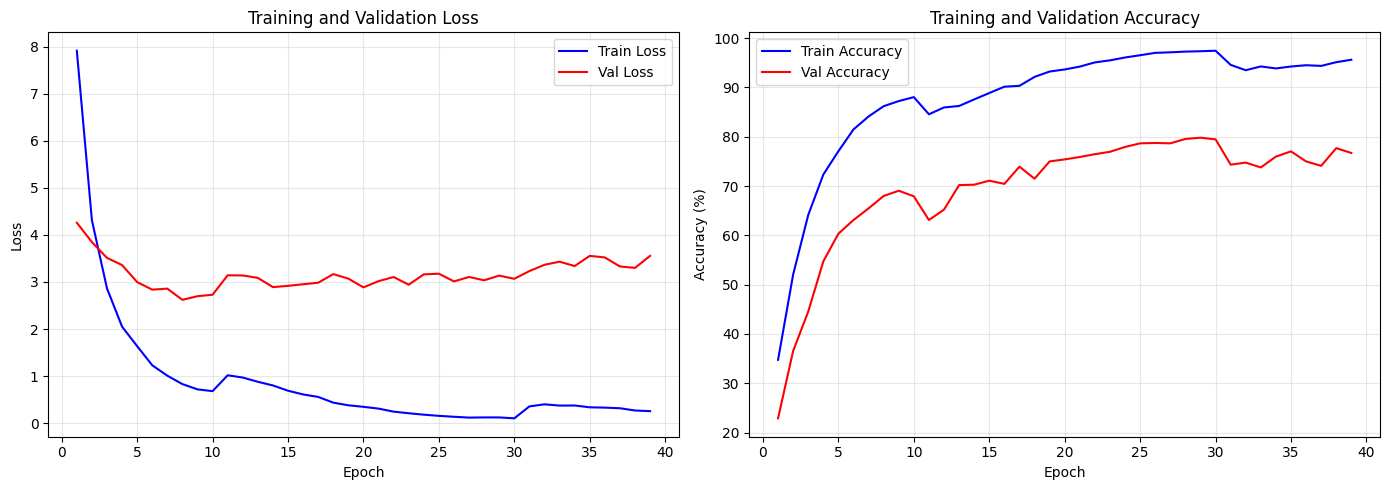

In [13]:
# Cell 14: Plot Training History
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(history['train_loss']) + 1)

# Loss
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy')
ax2.plot(epochs, history['val_acc'], 'r-', label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()


In [14]:
# Cell 15: Test Evaluation
print("\n" + "="*70)
print("EVALUATING ON TEST SET")
print("="*70)

# Load best model
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate on test set
test_results = validate(model, test_loader, criterion, config.DEVICE)

print(f"\n🎯 TEST RESULTS:")
print(f"   Accuracy: {test_results['accuracy']:.2f}%")
print(f"   Loss: {test_results['loss']:.4f}")


EVALUATING ON TEST SET


Validating: 100%|██████████| 48/48 [00:09<00:00,  5.03it/s]


🎯 TEST RESULTS:
   Accuracy: 81.68%
   Loss: 2.6404


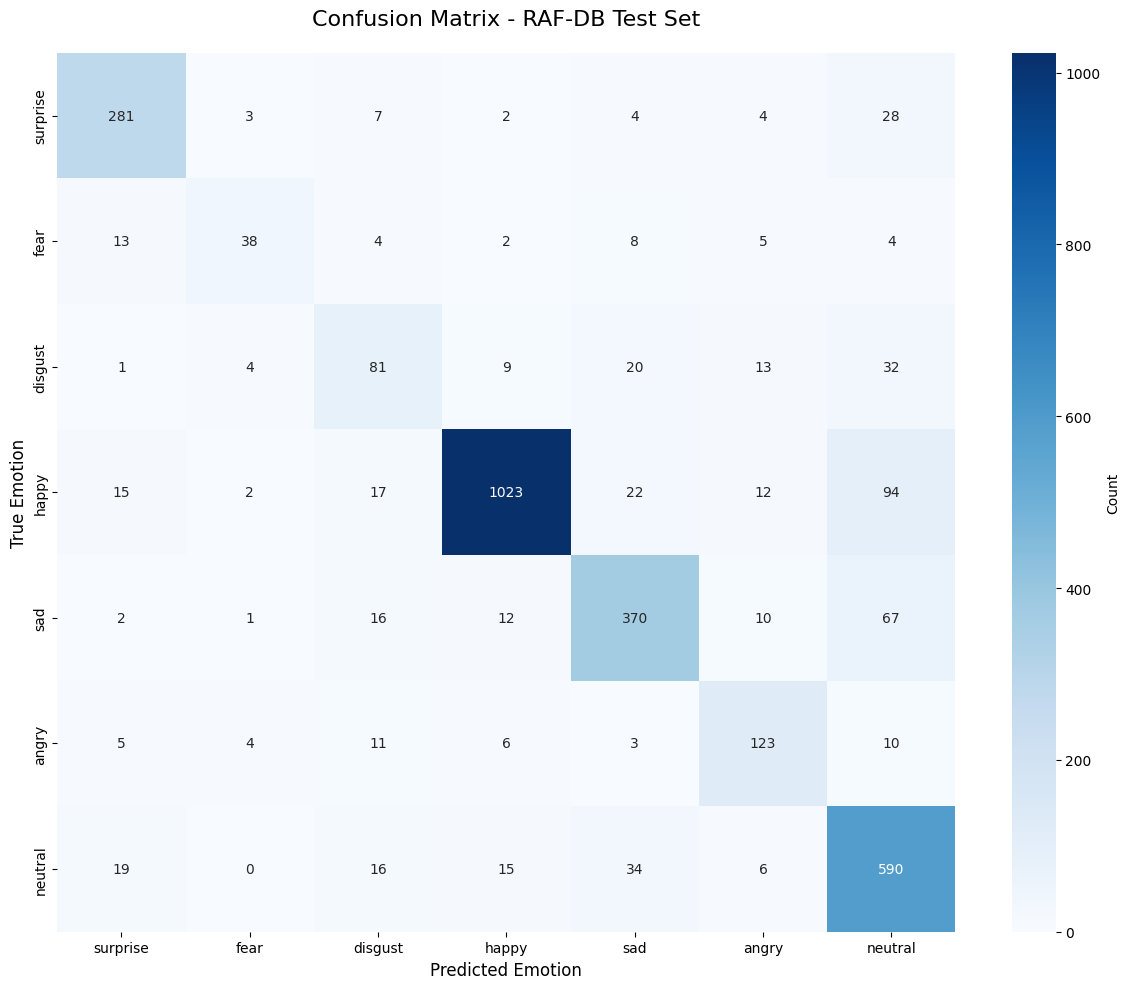

In [15]:
# Cell 16: Confusion Matrix
# Confusion Matrix
cm = confusion_matrix(test_results['labels'], test_results['predictions'])

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=list(config.IDX_TO_EMOTION.values()),
    yticklabels=list(config.IDX_TO_EMOTION.values()),
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - RAF-DB Test Set', fontsize=16, pad=20)
plt.ylabel('True Emotion', fontsize=12)
plt.xlabel('Predicted Emotion', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [16]:
# Cell 17: Classification Report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)

report = classification_report(
    test_results['labels'],
    test_results['predictions'],
    target_names=list(config.IDX_TO_EMOTION.values()),
    digits=4
)
print(report)


CLASSIFICATION REPORT
              precision    recall  f1-score   support

    surprise     0.8363    0.8541    0.8451       329
        fear     0.7308    0.5135    0.6032        74
     disgust     0.5329    0.5062    0.5192       160
       happy     0.9570    0.8633    0.9077      1185
         sad     0.8026    0.7741    0.7881       478
       angry     0.7110    0.7593    0.7343       162
     neutral     0.7152    0.8676    0.7841       680

    accuracy                         0.8168      3068
   macro avg     0.7551    0.7340    0.7402      3068
weighted avg     0.8258    0.8168    0.8182      3068



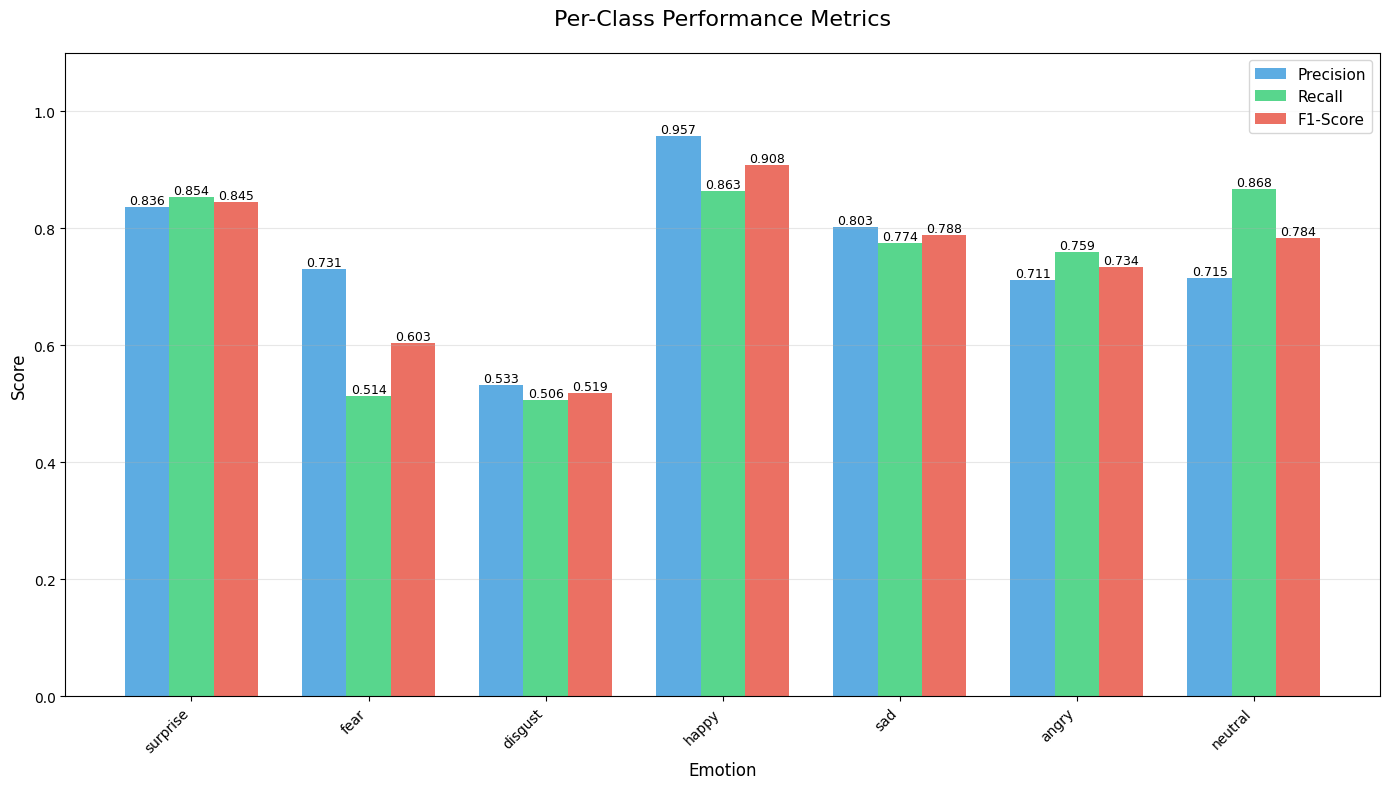


PER-CLASS STATISTICS
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
surprise        0.8363       0.8541       0.8451       329       
fear            0.7308       0.5135       0.6032       74        
disgust         0.5329       0.5062       0.5192       160       
happy           0.9570       0.8633       0.9077       1185      
sad             0.8026       0.7741       0.7881       478       
angry           0.7110       0.7593       0.7343       162       
neutral         0.7152       0.8676       0.7841       680       
----------------------------------------------------------------------
Overall         0.7551       0.7340       0.7402       3068      


In [17]:
# Cell 18: Per-Class Accuracy (continued)
from sklearn.metrics import precision_recall_fscore_support

# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    test_results['labels'],
    test_results['predictions'],
    average=None
)

# Create visualization
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(config.IDX_TO_EMOTION))
width = 0.25

bars1 = ax.bar(x - width, precision, width, label='Precision', alpha=0.8, color='#3498db')
bars2 = ax.bar(x, recall, width, label='Recall', alpha=0.8, color='#2ecc71')
bars3 = ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8, color='#e74c3c')

ax.set_xlabel('Emotion', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance Metrics', fontsize=16, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(list(config.IDX_TO_EMOTION.values()), rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Print per-class statistics
print("\n" + "="*70)
print("PER-CLASS STATISTICS")
print("="*70)
print(f"{'Emotion':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-"*70)

for i, emotion in config.IDX_TO_EMOTION.items():
    print(f"{emotion:<15} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {int(support[i]):<10}")

print("-"*70)
print(f"{'Overall':<15} {precision.mean():<12.4f} {recall.mean():<12.4f} {f1.mean():<12.4f} {int(support.sum()):<10}")


In [18]:
# Cell 19: Analyze Confusion Patterns
print("\n" + "="*70)
print("TOP CONFUSION PATTERNS")
print("="*70)

# Find top confusions (excluding diagonal)
confusion_pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i][j] > 0:
            true_emotion = config.IDX_TO_EMOTION[i]
            pred_emotion = config.IDX_TO_EMOTION[j]
            count = cm[i][j]
            total = cm[i].sum()
            percentage = (count / total) * 100
            confusion_pairs.append((true_emotion, pred_emotion, count, percentage))

# Sort by count
confusion_pairs.sort(key=lambda x: x[2], reverse=True)

print("\nTop 10 confusion patterns:")
print(f"{'True':<12} {'Predicted':<12} {'Count':<8} {'% of True Class':<15}")
print("-"*55)
for true_em, pred_em, count, pct in confusion_pairs[:10]:
    print(f"{true_em:<12} {pred_em:<12} {count:<8} {pct:>6.2f}%")


TOP CONFUSION PATTERNS

Top 10 confusion patterns:
True         Predicted    Count    % of True Class
-------------------------------------------------------
happy        neutral      94         7.93%
sad          neutral      67        14.02%
neutral      sad          34         5.00%
disgust      neutral      32        20.00%
surprise     neutral      28         8.51%
happy        sad          22         1.86%
disgust      sad          20        12.50%
neutral      surprise     19         2.79%
happy        disgust      17         1.43%
sad          disgust      16         3.35%


In [19]:
# Cell 20: SAD vs HAPPY Confusion Analysis
print("\n" + "="*70)
print("SAD vs HAPPY CONFUSION ANALYSIS")
print("="*70)

sad_idx = config.EMOTION_TO_IDX['sad']
happy_idx = config.EMOTION_TO_IDX['happy']

# Sad predicted as Happy
sad_as_happy = cm[sad_idx][happy_idx]
total_sad = cm[sad_idx].sum()
sad_as_happy_pct = (sad_as_happy / total_sad) * 100 if total_sad > 0 else 0

# Happy predicted as Sad
happy_as_sad = cm[happy_idx][sad_idx]
total_happy = cm[happy_idx].sum()
happy_as_sad_pct = (happy_as_sad / total_happy) * 100 if total_happy > 0 else 0

print(f"\nSad → Happy:  {sad_as_happy}/{total_sad} ({sad_as_happy_pct:.2f}%)")
print(f"Happy → Sad:  {happy_as_sad}/{total_happy} ({happy_as_sad_pct:.2f}%)")
print(f"Total confusion: {sad_as_happy + happy_as_sad} cases")

if sad_as_happy_pct < 10 and happy_as_sad_pct < 10:
    print("\n✅ EXCELLENT! SAD/HAPPY confusion is below 10%")
elif sad_as_happy_pct < 20 and happy_as_sad_pct < 20:
    print("\n🟢 GOOD! SAD/HAPPY confusion is acceptable (<20%)")
else:
    print("\n⚠️  SAD/HAPPY confusion still needs improvement")


SAD vs HAPPY CONFUSION ANALYSIS

Sad → Happy:  12/478 (2.51%)
Happy → Sad:  22/1185 (1.86%)
Total confusion: 34 cases

✅ EXCELLENT! SAD/HAPPY confusion is below 10%


In [20]:
# Cell 21: Save Model (BULLETPROOF VERSION)
print("\n" + "="*70)
print("SAVING MODEL")
print("="*70)

import os
import gc

# 1. Clear memory FIRST
print("Clearing GPU memory...")
torch.cuda.empty_cache()
gc.collect()

# 2. Move model to CPU (critical for saving)
print("Moving model to CPU...")
model = model.cpu()

# 3. Save ONLY essential data (no history, no extra stuff)
save_path = '/kaggle/working/rafdb_model_final.pth'

try:
    print(f"Saving to: {save_path}")
    
    # MINIMAL save - only what's needed
    save_dict = {
        'model_state_dict': model.state_dict(),
        'epoch': checkpoint.get('epoch', 0),
        'best_val_acc': best_val_acc,
        'test_accuracy': test_results['accuracy'],
    }
    
    torch.save(save_dict, save_path)
    
    # 4. VERIFY immediately
    print("Verifying save...")
    test_load = torch.load(save_path, map_location='cpu')
    
    # 5. Check file size
    file_size_mb = os.path.getsize(save_path) / (1024 * 1024)
    
    print(f"\n✅ SUCCESS!")
    print(f"   File: {save_path}")
    print(f"   Size: {file_size_mb:.2f} MB")
    print(f"   Keys: {list(test_load.keys())}")
    print(f"   Val Acc: {best_val_acc:.2f}%")
    print(f"   Test Acc: {test_results['accuracy']:.2f}%")
    
except Exception as e:
    print(f"\n❌ SAVE FAILED!")
    print(f"Error: {e}")
    
    # Emergency backup - save just weights
    print("\nAttempting emergency backup...")
    try:
        backup_path = '/kaggle/working/model_weights_only.pth'
        torch.save(model.state_dict(), backup_path)
        print(f"✅ Backup saved: {backup_path}")
    except Exception as e2:
        print(f"❌ Backup also failed: {e2}")

print("="*70)


SAVING MODEL
Clearing GPU memory...
Moving model to CPU...
Saving to: /kaggle/working/rafdb_model_final.pth
Verifying save...

✅ SUCCESS!
   File: /kaggle/working/rafdb_model_final.pth
   Size: 45.00 MB
   Keys: ['model_state_dict', 'epoch', 'best_val_acc', 'test_accuracy']
   Val Acc: 79.80%
   Test Acc: 81.68%



SAMPLE PREDICTIONS


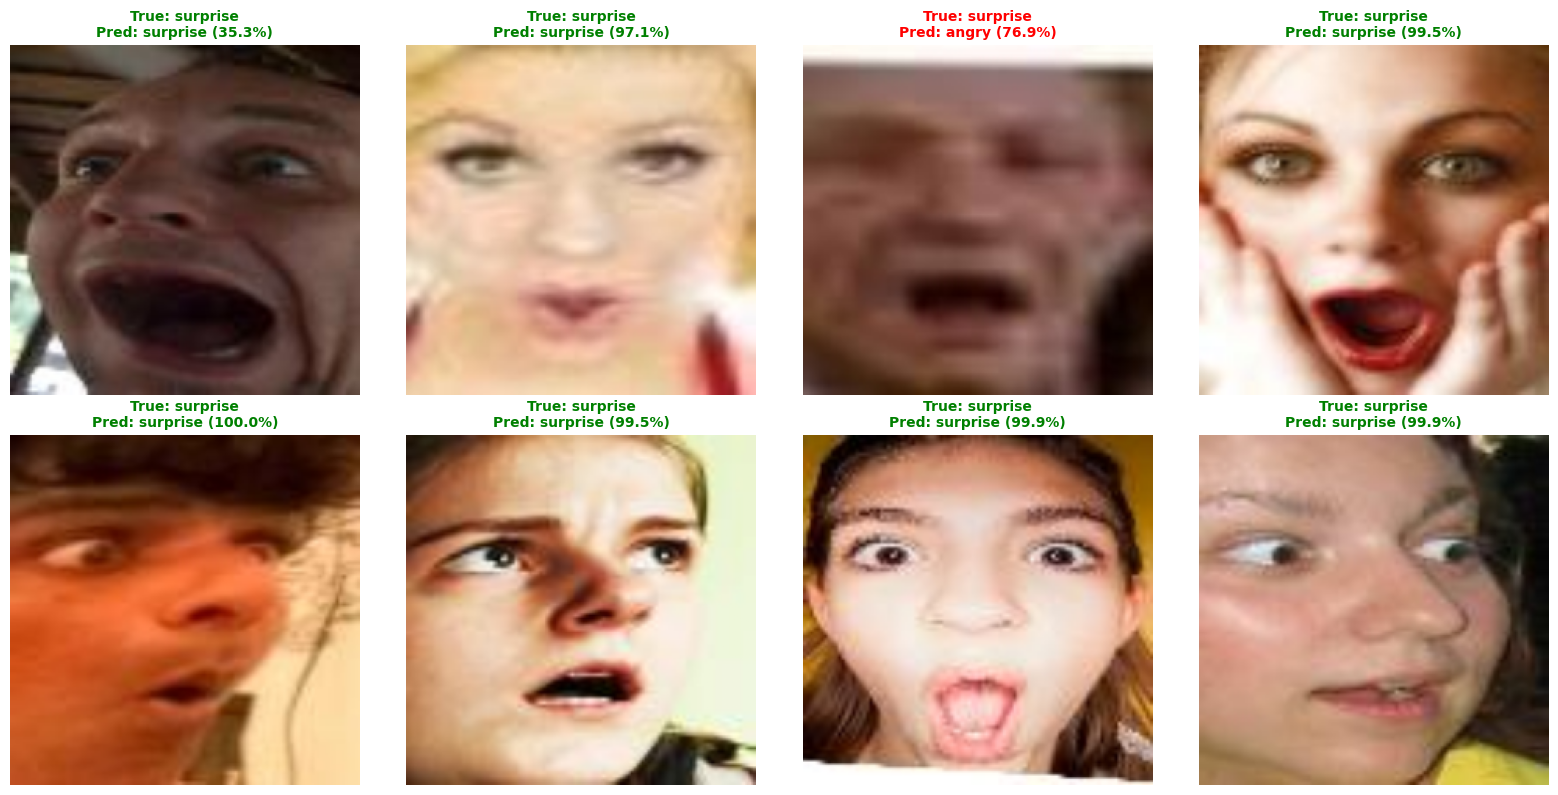

✅ Sample predictions visualized and saved


In [21]:
# ==============================================================================
# CELL 22: SAMPLE PREDICTIONS (FIXED - Device Sync)
# ==============================================================================

print("\n" + "="*70)
print("SAMPLE PREDICTIONS")
print("="*70)

# Get a batch from test set
model.eval()
model = model.to(config.DEVICE)  # ← FIX: Ensure model is on correct device

dataiter = iter(test_loader)
images, labels = next(dataiter)

# ✅ FIX: Move images to same device as model
images = images.to(config.DEVICE)
labels = labels.to(config.DEVICE)

# Make predictions
with torch.no_grad():
    emotion_logits, valence_logits, arousal_logits, dominance_logits = model(images)
    emotion_probs = F.softmax(emotion_logits, dim=1)
    predictions = torch.argmax(emotion_logits, dim=1)

# Move back to CPU for visualization
images = images.cpu()
labels = labels.cpu()
predictions = predictions.cpu()
emotion_probs = emotion_probs.cpu()

# Visualize first 8 samples
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

# Denormalize images for display
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

for i in range(min(8, len(images))):
    # Denormalize
    img = images[i] * std + mean
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    true_label = config.IDX_TO_EMOTION[labels[i].item()]
    pred_label = config.IDX_TO_EMOTION[predictions[i].item()]
    confidence = emotion_probs[i][predictions[i]].item()
    
    # Plot
    axes[i].imshow(img)
    axes[i].axis('off')
    
    # Color based on correct/incorrect
    color = 'green' if true_label == pred_label else 'red'
    
    axes[i].set_title(
        f"True: {true_label}\nPred: {pred_label} ({confidence:.1%})",
        fontsize=10,
        color=color,
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Sample predictions visualized and saved")
print("="*70)


ATTRIBUTE PREDICTION ACCURACY


Analyzing attributes: 100%|██████████| 48/48 [00:05<00:00,  8.69it/s]



Attribute Prediction Accuracies:
  Emotion:    81.68%
  Valence:    88.89%
  Arousal:    90.78%
  Dominance:  96.54%


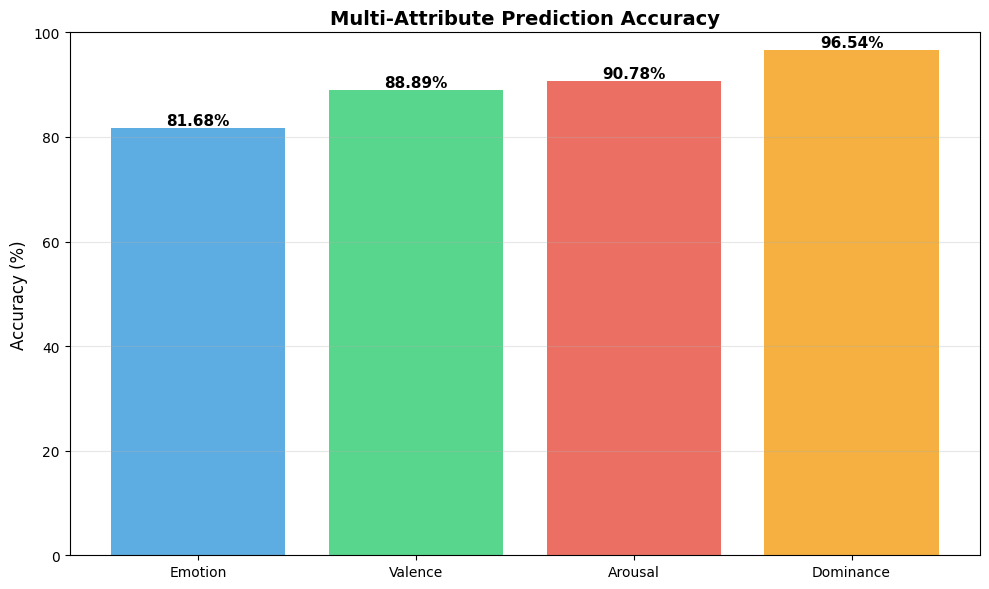

In [22]:
# Cell 23: Attribute Prediction Analysis
print("\n" + "="*70)
print("ATTRIBUTE PREDICTION ACCURACY")
print("="*70)

# Evaluate attribute predictions on test set
model.eval()

all_emotion_preds = []
all_valence_preds = []
all_arousal_preds = []
all_dominance_preds = []

all_emotion_labels = []
all_valence_labels = []
all_arousal_labels = []
all_dominance_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Analyzing attributes'):
        images = images.to(config.DEVICE)
        labels = labels.to(config.DEVICE)
        
        # Get attribute labels
        valence_labels, arousal_labels, dominance_labels = get_attribute_labels_batch(labels)
        
        # Predictions
        emotion_logits, valence_logits, arousal_logits, dominance_logits = model(images)
        
        emotion_preds = torch.argmax(emotion_logits, dim=1)
        valence_preds = torch.argmax(valence_logits, dim=1)
        arousal_preds = torch.argmax(arousal_logits, dim=1)
        dominance_preds = torch.argmax(dominance_logits, dim=1)
        
        all_emotion_preds.extend(emotion_preds.cpu().numpy())
        all_valence_preds.extend(valence_preds.cpu().numpy())
        all_arousal_preds.extend(arousal_preds.cpu().numpy())
        all_dominance_preds.extend(dominance_preds.cpu().numpy())
        
        all_emotion_labels.extend(labels.cpu().numpy())
        all_valence_labels.extend(valence_labels.numpy())
        all_arousal_labels.extend(arousal_labels.numpy())
        all_dominance_labels.extend(dominance_labels.numpy())

# Calculate accuracies
emotion_acc = accuracy_score(all_emotion_labels, all_emotion_preds) * 100
valence_acc = accuracy_score(all_valence_labels, all_valence_preds) * 100
arousal_acc = accuracy_score(all_arousal_labels, all_arousal_preds) * 100
dominance_acc = accuracy_score(all_dominance_labels, all_dominance_preds) * 100

print(f"\nAttribute Prediction Accuracies:")
print(f"  Emotion:    {emotion_acc:.2f}%")
print(f"  Valence:    {valence_acc:.2f}%")
print(f"  Arousal:    {arousal_acc:.2f}%")
print(f"  Dominance:  {dominance_acc:.2f}%")

# Visualize
attributes = ['Emotion', 'Valence', 'Arousal', 'Dominance']
accuracies = [emotion_acc, valence_acc, arousal_acc, dominance_acc]

plt.figure(figsize=(10, 6))
bars = plt.bar(attributes, accuracies, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'], alpha=0.8)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Multi-Attribute Prediction Accuracy', fontsize=14, fontweight='bold')
plt.ylim([0, 100])
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('attribute_accuracies.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# Cell 24: Summary and Next Steps
print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)

print(f"\n📊 Model Performance:")
print(f"   Architecture: {config.MODEL_NAME}")
print(f"   Training Time: {len(history['train_loss'])} epochs")
print(f"   Best Val Accuracy: {best_val_acc:.2f}%")
print(f"   Test Accuracy: {test_results['accuracy']:.2f}%")

print(f"\n📈 Multi-Attribute Performance:")
print(f"   Emotion:    {emotion_acc:.2f}%")
print(f"   Valence:    {valence_acc:.2f}%")
print(f"   Arousal:    {arousal_acc:.2f}%")
print(f"   Dominance:  {dominance_acc:.2f}%")

print(f"\n💾 Saved Files:")
print(f"   - rafdb_multi_attribute_final.pth (Complete model)")
print(f"   - training_history.png (Training curves)")
print(f"   - confusion_matrix.png (Test confusion matrix)")
print(f"   - per_class_metrics.png (Per-class performance)")
print(f"   - sample_predictions.png (Visual predictions)")
print(f"   - attribute_accuracies.png (Attribute performance)")

print(f"\n🎯 Confusion Analysis:")
if sad_as_happy_pct < 10 and happy_as_sad_pct < 10:
    print(f"   ✅ SAD/HAPPY confusion: RESOLVED!")
else:
    print(f"   ⚠️  SAD/HAPPY confusion: {sad_as_happy_pct:.1f}% + {happy_as_sad_pct:.1f}%")

print(f"\n📥 Download Model:")
print(f"   Click on 'rafdb_multi_attribute_final.pth' in the output section")
print(f"   Use this in your VS Code project for deployment!")

print("\n" + "="*70)
print("✅ KAGGLE TRAINING COMPLETE!")
print("="*70)



TRAINING SUMMARY

📊 Model Performance:
   Architecture: resnet18
   Training Time: 39 epochs
   Best Val Accuracy: 79.80%
   Test Accuracy: 81.68%

📈 Multi-Attribute Performance:
   Emotion:    81.68%
   Valence:    88.89%
   Arousal:    90.78%
   Dominance:  96.54%

💾 Saved Files:
   - rafdb_multi_attribute_final.pth (Complete model)
   - training_history.png (Training curves)
   - confusion_matrix.png (Test confusion matrix)
   - per_class_metrics.png (Per-class performance)
   - sample_predictions.png (Visual predictions)
   - attribute_accuracies.png (Attribute performance)

🎯 Confusion Analysis:
   ✅ SAD/HAPPY confusion: RESOLVED!

📥 Download Model:
   Click on 'rafdb_multi_attribute_final.pth' in the output section
   Use this in your VS Code project for deployment!

✅ KAGGLE TRAINING COMPLETE!


In [24]:
# Cell 25: Export Confusion Matrix Data
# Save confusion matrix as CSV for further analysis
confusion_df = pd.DataFrame(
    cm,
    index=[f"True_{em}" for em in config.IDX_TO_EMOTION.values()],
    columns=[f"Pred_{em}" for em in config.IDX_TO_EMOTION.values()]
)
confusion_df.to_csv('confusion_matrix.csv')

print("\n✅ Confusion matrix saved as CSV")


✅ Confusion matrix saved as CSV
